# Recommendations with IBM

In this notebook, we analyze real interactions between users and articles on the IBM Watson Studio Platform to develop a recommendation system. In efforts to help drive engagement by making article recommendations that users are most likely to engage with.

In this notebook we explore 3 different types of recommendation systems: Rank Based, Collaborative Filtering and Content Based.

![](https://i.imgur.com/XyxLUFF.png)

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Conclusions](#conclusions)<br>
VII. [Resources](#resources)

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [152]:
# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [153]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [154]:
df.shape[0]

45993

In [155]:
df.groupby('article_id').size()

article_id
0.0       14
2.0       58
4.0       13
8.0       85
9.0       10
          ..
1440.0    10
1441.0     8
1442.0     4
1443.0    22
1444.0     5
Length: 714, dtype: int64

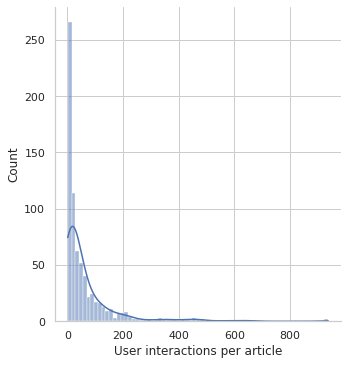

In [156]:
user_interactions_per_article = df.groupby('article_id').size()

# Styling for plot
sns.set(rc={'figure.figsize':(8.7,5.27)})
sns.set_style('whitegrid')
sns.color_palette("husl")


fig = sns.displot(user_interactions_per_article, kde=True, palette="Greens_d")
fig.set(xlabel="User interactions per article")



In [157]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby('article_id').size().median() # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = max(df.groupby('article_id').size()) # The maximum number of user-article interactions by any 1 user is ______.

print("Median Views per Article: ", median_val)
print("Most views on an Article: ", max_views_by_user)

Median Views per Article:  25.0
Most views on an Article:  937


In [158]:
df_content.shape[0]

1056

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [159]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'])
df_content.shape[0]

1051

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [160]:
# The number of unique articles that have an interaction with a user
df.groupby('article_id').size()

article_ids = df['article_id'].unique()
unique_views = []

for i in article_ids:
    unique_view_count = df[df['article_id']==i]['email'].nunique()
    unique_views.append(unique_view_count)

data = {'article_id': article_ids, 'unique_views': unique_views}
df_unique_views = pd.DataFrame(data=data)
df_unique_views

,article_id,unique_views
0,1430.0,237
1,1314.0,345
2,1429.0,397
3,1338.0,255
4,1276.0,238
...,...,...
709,1156.0,2
710,555.0,2
711,708.0,2
712,575.0,2


In [161]:
# Number of user article interactions
user_article_interactions = df.shape[0]
print("Number of user-article interactions: ", user_article_interactions)

Number of user-article interactions:  45993


In [162]:
# Number of unique articles on the IBM platform
total_articles = df_content.shape[0]
print("Total articles: ", total_articles)

Total articles:  1051


In [163]:
# Number of unique articles
unique_articles = len(df['article_id'].unique())
print("Unique articles: ", unique_articles)

Unique articles:  714


In [164]:
unique_users = len(set(df['email']))-1
print("Unique Users: ", unique_users)

Unique Users:  5148


In [165]:
# Number of user article interactions
user_article_interaction = df.shape[0]
print("User Article Interactions: ", user_article_interaction)

User Article Interactions:  45993


`4.` Using the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [166]:
df_unique_views.sort_values(by="unique_views")

,article_id,unique_views
515,1200.0,1
563,1344.0,1
693,675.0,1
433,724.0,1
695,662.0,1
...,...,...
145,1398.0,329
1,1314.0,345
19,1364.0,388
2,1429.0,397


In [167]:
# Grouping by article_id and counting number of times a user views that particular article id
df_article_views = df.groupby('article_id').count().sort_values(by='title')

In [168]:
# Most viewed article in the database
most_viewed_article_id = str(df_article_views.iloc[:,-1].tail(1).index.values[0])
print("Most viewed article id: ", most_viewed_article_id)

Most viewed article id:  1429.0


In [169]:
max_views = df_article_views.iloc[:,-1].tail(1).values[0]
print("Max views on an article: ", max_views)

Max views on an article:  937


In [170]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [171]:
# Median value of interactions
number_of_interactions = []
for i in set(df['user_id']):
    interactions = df[df['user_id']==i].shape[0]
    number_of_interactions.append(interactions)

median_val = np.median(number_of_interactions)
print(median_val)
    

3.0


In [172]:
# Max number of user article interactions by any 1 user is
max_views_by_user = max(number_of_interactions)
print(max_views_by_user)


364


In [173]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [174]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    
    df_views = df.melt(id_vars="article_id", value_vars="title")
    df_views['count'] = df_views.groupby('value')['value'].transform('count')
    df_views = df_views.drop_duplicates()
    
    top_articles = df_views.sort_values(by=['count'], ascending=False)[:n]['value']
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Counting the number of times an article appears and dropping duplicates
    df_views = df.melt(id_vars="article_id", value_vars="title")
    df_views['count'] = df_views.groupby('value')['value'].transform('count')
    df_views = df_views.drop_duplicates()
    
    # Sorting top to bottom # of views
    top_articles = df_views.sort_values(by=['count'], ascending=False)[:n]['article_id']
 
 
    return top_articles # Return the top article ids

In [175]:
print(get_top_articles(10))
print(get_top_article_ids(10))

2             use deep learning for image classification
66           insights from new york car accident reports
37                        visualize car data with brunel
42     use xgboost, scikit-learn & ibm watson machine...
29     predicting churn with the spss random tree alg...
1           healthcare python streaming application demo
154    finding optimal locations of new store using d...
14              apache spark lab, part 1: basic concepts
31               analyze energy consumption in buildings
56     gosales transactions for logistic regression m...
Name: value, dtype: object
2      1429.0
66     1330.0
37     1431.0
42     1427.0
29     1364.0
1      1314.0
154    1293.0
14     1170.0
31     1162.0
56     1304.0
Name: article_id, dtype: float64


In [176]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [177]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().notnull().unstack().replace({np.NaN: 0, True: 1})
    
    return user_item # return the user_item matrix 

# Creating and storing the user_item matrix
user_item = create_user_item_matrix(df)
user_item.to_pickle('user_item_matrix.p')


In [178]:
## Tests: 
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [179]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user_similarity = dict()

    for i in user_item.index:
        user_similarity[i] = np.dot(user_item.loc[user_id, :], user_item.loc[i, :])

    # Removing the user id from the list of similarities
    del user_similarity[user_id]

    # sort by similarity
    similarity = sorted(user_similarity.items(), key=lambda x: x[1], reverse=True)
    
    # create list of just the ids
    most_similar_users = [ similar_user_id for similar_user_id, _ in similarity]

    return most_similar_users # return a list of the users in order from most to least similar
        

In [180]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [181]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # flattening the list of article names
    article_names = [df[df['article_id']==float(i)]['title'].values[0] for i in article_ids]
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''

    article_ids = []
    
    # Appending article ids that user have seen into user_article_ids
    for k, v in user_item.loc[user_id].items():
        if v==1:
            article_ids.append(k)

    article_names = get_article_names(article_ids)
    article_ids = list(map(str, article_ids))
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    recs = []
    user_has_seen = []

    # Storing article ids that similar users have seen and what the user has already seen
    similar_users = find_similar_users(user_id)
    user_has_seen, _ = get_user_articles(user_id)

    increment = 0

    # Computing the intersection of the similar users and the user
    while len(recs) <= m:
        similar_articles, _ = get_user_articles(similar_users[increment])

        rec = [i for i in similar_articles if i not in user_has_seen]

        if rec:
            recs.append(rec)
        increment += 1
    
    # Formating the output in a way that makes sense
    recs = [rec for article_rec in recs for rec in article_rec]
    recs = list(set(recs))
    recs = np.sort(recs)[:m]
    
    return recs # return your recommendations for this user_id    

In [182]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'the pandas data analysis library',
 'data tidying in data science experience',
 'mapping points with folium',
 'a comparison of logistic regression and naive bayes ',
 'a tensorflow regression model to predict house values',
 'access mysql with python',
 'access mysql with r',
 'access postgresql with r']

In [183]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [184]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''

    # compute similarity of each user to the provided user
    user_similarity = dict()

    for i in user_item.index:
        user_similarity[i] = np.dot(user_item.loc[user_id, :], user_item.loc[i, :])

    # Removing the user id from the list of similarities
    del user_similarity[user_id]

    # sort by similarity
    similarity = sorted(user_similarity.items(), key=lambda x: x[1], reverse=True)

    # Unpacking similarity
    similar_user_ids, similarity_scores = zip(*similarity)

    # Calculating num of interactions viewed each user
    num_interactions = []
    for similar_user in similar_user_ids:
        interactions = sum(user_item.loc[similar_user, :])
        num_interactions.append(interactions)
        
    # print(num_interactions)
    data = {'user_id': similar_user_ids, 'similarity_score': similarity_scores, 'num_interaction': num_interactions}
    neighbors_df = pd.DataFrame(data=data)
    
    # Sorting by similarity score and number of interactions
    neighbors_df.sort_values(by=['similarity_score', 'num_interaction'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''

    recs = []
    rec_names = []
    neighbors_df = get_top_sorted_users(user_id)
    increment = 0

    # Adding the top user's article ids and names and breaking while loop once
    while m >= increment:
        article_ids, article_names = get_user_articles(neighbors_df.loc[increment]['user_id'])
        for uid, name in zip(article_ids, article_names):
            recs.append(uid)
            rec_names.append(name)
            increment += 1
        
    recs = recs[:m]
    rec_names = rec_names[:m]
    
    return recs, rec_names

In [185]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['43.0', '109.0', '111.0', '112.0', '164.0', '213.0', '225.0', '232.0', '313.0', '337.0']

The top 10 recommendations for user 20 are the following article names:
['deep learning with tensorflow course by big data university', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', 'building custom machine learning algorithms with apache systemml', 'learn tensorflow and deep learning together and now!', 'modeling energy usage in new york city', 'a visual explanation of the back propagation algorithm for neural networks', 'self-service data preparation with ibm data refinery', 'what is machine learning?', 'generalization in deep learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [186]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).loc[0]['user_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).loc[9]['user_id'] # Find the 10th most similar user to user 131

In [187]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

As a new user there are no similarity score since user hasn't yet seen any articles yet. Therefore we can start off with the articles that have the most interactions. We have already developed a function get_top_article_ids for a new user as well as use it for users that haven't yet seen many articles yet as it will be difficult to gauge their similarity.

Therefore the rank based approach to recommendation would be more beneficial than the collaborative filtering method due to the cold start problem of not being able to know what articles the user would like to see.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [188]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = map(str, get_top_article_ids(10))# Your recommendations here



In [189]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [190]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [191]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>


`1.` **user_item** matrix was created above in **question 1** of **Part III** above and being loaded again.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [192]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [193]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [194]:
# Performing SVD on the User-Item Matrix 
u, s, vt = np.linalg.svd(user_item_matrix)

This matrix doesn't contain ratings like in the example in the lecture but rather which movies a 

`3.` Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

Text(0.5, 1.0, 'Accuracy vs. Number of Latent Features')

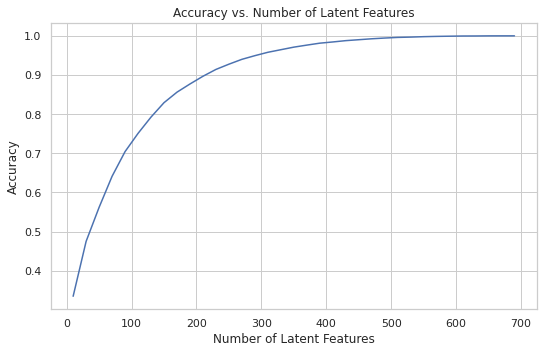

In [195]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [196]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # train and test matrix
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # test ids and article ids
    test_idx = list(user_item_test.index.values)
    test_arts = user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [197]:
# Number of users we can make predictions for the test set
user_ids_in_both_sets = [i for i in user_item_train.index.values if i in test_idx]
num_of_user_pred = len(user_ids_in_both_sets)

print("Number of users we can make predictions for in the test set: ", num_of_user_pred)

Number of users we can make predictions for in the test set:  20


In [198]:
# number of users that we can make predictions for giving us the amount we can't predict
print("Number of users in the test set unable to make predictions due to cold start: ", user_item_test.shape[0]-num_of_user_pred)

Number of users in the test set unable to make predictions due to cold start:  662


In [199]:
# Number of articles we can make predictions for in the test test
articles_in_both_sets = [i for i in user_item_train.columns if i in test_arts]
num_of_article_pred = len(articles_in_both_sets)

print("Number of articles we can make predictions for in the test set: ", num_of_article_pred)

Number of articles we can make predictions for in the test set:  574


In [200]:
# articles in the test set we aren't able to make predictions for (substracting by 574 because they are common)
print("Number of articles in the test set unable to make predictions due to cold start: ", len(test_arts)-num_of_article_pred)

Number of articles in the test set unable to make predictions due to cold start:  0


In [201]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many articles can we make predictions for in the test set?': b,# letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.


In [202]:
# fit SVD on the user_item_train matrix

u_train, s_train, vt_train = np.linalg.svd(user_item_train)

In [203]:
# Creating a boolean list of which ids and articles are present in test_idx and user_item_train
train_common_idx = user_item_train.index.isin(test_idx)
train_common_arts = user_item_train.columns.isin(test_arts)

In [204]:
# Subset of the user_item_test that were found to be common for articles and users
u_test = u_train[train_common_idx, :]
vt_test = vt_train[:, train_common_arts]

user_item_test_subset = user_item_test.loc[user_ids_in_both_sets]

In [205]:
num_latent_feats = np.arange(10,700+10,20)
train_sum_errs = []
test_sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_train_estimate = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_test_estimate = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs_test = np.subtract(user_item_test_subset, user_item_test_estimate)
    diffs_train = np.subtract(user_item_train, user_item_train_estimate)
    
    # total errors and keep track of them
    train_err = np.sum(np.sum(np.abs(diffs_train)))
    test_err = np.sum(np.sum(np.abs(diffs_test)))
    
    train_sum_errs.append(train_err)
    test_sum_errs.append(test_err)
    

# Plot style
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.color_palette("husl")

# Comparing the train and test user_item matrix
fig = sns.lineplot(x= num_latent_feats, y= 1 - np.array(train_sum_errs)/(user_item_train.shape[0]*user_item_train.shape[1]), label="Train")
fig = sns.lineplot(x= num_latent_feats, y= 1 - np.array(test_sum_errs)/(user_item_test_subset.shape[0]*user_item_test_subset.shape[1]), label="Test")
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
fig.set(title='Accuracy vs. Number of Latent Features')
sns.set_context("talk")

plt.legend()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

The results of the figure comparing the train user item matrix indicates that it is improving as the number of latent features is increasing. However looking at the test user item matrix the opposite is found that the accuracy of the model is decreasing. This may indicate that our model is being overfit to the training model. 

Another issue is that there are very few user ids in both the test and train to make predictions and thus unable to make predictions for everyone. Thus ultimately being able to use SVD to make recommendations is very limited.

## <a class="anchor" id="conclusions"> Conclusions </a>

Exploring the dataset we have found that there are 714 unique articles with a median view of 25 per article. One of the major issues when developing a recommendation system is the cold start problem. This is when we do not have any information on new users to be able to provide recommendations through collaborative filtering based systems. One way around this is to use a rank based recommendation system and show articles that have the most unique user interactions as those articles.

The rank based recommendations are useful to new users that have no interactions. This can be a useful as a starting recommendation and than if there is engagement and there are user and article interactions switch to the collaborative filtering based recommendation system. In order to further improve rank based recommendations we could also implement thumbs up or thumbs down system to check if users actually enjoyed the recommendation since just engagement alone doesn't mean they liked the article. 

SVD can help predict the training model but accuracy drops when increasing the number of latent factors in the model. Thus this is an indication of overfitting to the training set. Further attempts can be made to remedy this by having more user interactions that are present in both the training and the test data so we can make predictions as there are only 20 common users.

Further analysis at impressions and click through rate based on which recommendation system to use can be done. Ideally we want to use both in some combination however this is just an assumption in order to verify this we would need to conduct an experiment. In which we need to determine if there are more engagement using a particular recommendation system (rank abased, content or collaborative filtering). This can be done through A/B testing in which we can set up rank based recommendations as the control. We can measure engagement by using a binary classification such as thumps up or thumbs down button that users can click on to show if they enjoyed the recommendation. Using a hypothesis test like chi square test we can determine which sample group has more successful user engagements.


In [ ]:
# Converting notebook to html
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb', '--to', 'html'])

[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] Writing 790559 bytes to Recommendations_with_IBM.html


0

## Resources
https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
http://infolab.stanford.edu/~ullman/mmds/ch11.pdf
